In [1]:
"""
This script fetches landsat 8 raw data near rs09 corrects it for surface kinetic temperature

It then computes the average temperature at RS09 and compares to the number of events detected
"""

'\nThis script fetches landsat 8 raw data near rs09 corrects it for surface kinetic temperature\n\nIt then computes the average temperature at RS09 and compares to the number of events detected\n'

In [2]:
import ee
ee.Initialize()
import pprint #pretty print for easier debuging 
import numpy as np #for debugging manual raster calculations
import copy
import datetime
try:
    import geemap
except ModuleNotFoundError:
    print("probably on collabratory, final map wont work")
#import warnings #pandas is making changes to how it handles time zones in the future, Ill deal with it later 
#warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import altair as alt

In [3]:
#location of wheather station 
#lon/lat
mgtLoc = ee.Geometry.Point([360-165.01,-80.00])
RS09Loc= ee.Geometry.Point([360-159.848007,-79.42])
#how many km is the buffer
bufferSize=1
RS09Region=RS09Loc.buffer(bufferSize*1000) #get everything within the buffer
scale=bufferSize*1000 #size of the area to average over when computing thermal resolutions
#I am assuming the emissivity of snow
snow_emiss=0.97
#plot save location
savePlot="./vegaPlots/"
saveCharts=True

In [4]:
#need raw tier 2 colelciton
#https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T2#image-properties
collection = ee.ImageCollection("LANDSAT/LC08/C02/T2").filterDate('2014-11-01', '2016-11-01').filterBounds(
    RS09Region)
#how many images are in this collection?
print(collection.size().getInfo())

255


### compute thermal temperature for a single image
Spectral Radiance

$L_{\lambda} = M_{l}*B10_{Val}+A_{L}$

In [5]:
#just for the purposes of figuring this out I am doing this opperation on one image, then on all of them
#compute temperature on one image
testImage=collection.select("B10").first()
testQAFields=collection.select("QA_PIXEL").first()
imageMeta =  testImage.getInfo()
print("image ID=" + imageMeta['id'])
#get the b10 value for the pixel(s) of interest near margret
DNValue=testImage.sample(RS09Region,scale).first().get("B10").getInfo()
SpectralRadiance=imageMeta['properties']['RADIANCE_MULT_BAND_10']*DNValue+imageMeta['properties']['RADIANCE_ADD_BAND_10']

image ID=LANDSAT/LC08/C02/T2/LC08_022118_20141103


### Now Compute Brightness Temperature
$T_{k} = \frac{K_{2}}{ln(\frac{k_1}{L_{\lambda}}+1)} $

In [6]:
bt=imageMeta['properties']['K2_CONSTANT_BAND_10']/(np.log((imageMeta['properties']['K1_CONSTANT_BAND_10']/SpectralRadiance)+1))
print("bt="+str(bt))

bt=251.03530324289088


### Now Evaluate Radiant Temperature

$T_{radiant}=\epsilon^{\frac{1}{4}}T_{kinetic}$

$ \epsilon_{drysnow} \approxeq 0.97 $

In [7]:
kt=np.power(0.97,0.25)*bt
print("kt="+str(kt))
print("cloud coverage on this day="+str(imageMeta['properties']["CLOUD_COVER"])+"%")

kt=249.13097887428617
cloud coverage on this day=0%


### Now this process is implemented using the earth engine back end to return a series of temperatures at margret

please be careful of the buffer size selected for margret since this can easily become computationaly expensive for large buffers

In [8]:
def calcSpectralRadiance(DNValue):
    return imageMeta['properties']['RADIANCE_MULT_BAND_10']*DNValue+imageMeta['properties']['RADIANCE_ADD_BAND_10']
    
def calcBrightnessTemp(SpectralRadiance):
    return imageMeta['properties']['K2_CONSTANT_BAND_10']/(np.log((imageMeta['properties']['K1_CONSTANT_BAND_10']/SpectralRadiance)+1))

def calcRadiantTemp(bt,emiss=snow_emiss):
    return np.power(emiss,0.25)*bt

#function evaluated on each image in the image collection
#these values are added to the temperatures data strucutre
#returns a pandas data array
def calculateKineticTemps(B10Values):    
    #column names
    columns=B10Values.pop(0)
    #additional columns
    columns.append("surface_temp")
    columns.append("weatherstation_temp")
    columns.append("weatherstation_wind")
    for dn in B10Values:
        try:
            SR=calcSpectralRadiance(dn[-1])
            bt=calcBrightnessTemp(SR)
            t=calcRadiantTemp(bt)
            dn.append(t)
            #add an empty space to be replaced with the weather station reported temperature later
            dn.append(None)
            dn.append(None)
        except TypeError:
            #no problem an image was missing (ususally because of cloud cover) proceed to next image
            dn.append(None)
            dn.append(None)
            dn.append(None)
    
    #convert to a pandas data frame
    df=pd.DataFrame(B10Values,columns=columns)
    #remove rows without data
    #df=df[['longitude', 'latitude', 'time', *["B10","surface_temp"]]].dropna()
    df=df.dropna(subset=["B10","surface_temp"])
    #index by date time
    df['datetime'] = pd.to_datetime(df['time'],unit='ms')
    return df

    

In [9]:
### subset the collection into a collection of just b10 images
B10Images=collection.select("B10")
%time B10Values=B10Images.getRegion(RS09Region,scale).getInfo()


CPU times: user 18.5 ms, sys: 2.88 ms, total: 21.4 ms
Wall time: 2.93 s


In [10]:
#get all of the surface temperature estimates for margret 
rs09Temps=calculateKineticTemps(B10Values)


### Make a simple scatter plot of remotely sensed temperatures

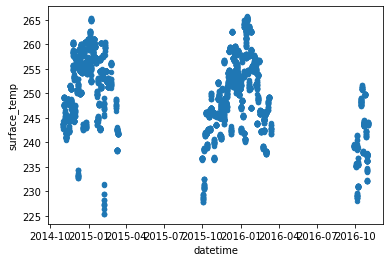

In [11]:
ax1=rs09Temps.plot.scatter(
    x="datetime",
    y="surface_temp"
)

In [12]:
#dump the probabl eronious events below 225 Kelvin
rs09Temps=rs09Temps[rs09Temps["surface_temp"]>=225]

### Make A Nicer Plot that Compares The Temperature Values From MGT to those you have comptued

In [13]:
#try loading the catalogue from disk since it is large 100 mb, otherwise fetch it from my github page
try:
    catalogue=pd.read_csv("./thermalAndSeismicData/catalogue.csv")
except FileNotFoundError:
    print("loading from github")
    catalogue=pd.read_csv("https://github.com/firstkingofrome/RS_Thermal_final_project/blob/main/thermalAndSeismicData/catalogue.csv?raw=true")
#index catalogue by time stamp
catalogue['pick_time']=pd.to_datetime(catalogue['pick_time'],utc=False)
#catalogue=catalogue.set_index('pick_time')

In [14]:
### generate a new data frame with the landsat temperature and the number of events that happend in the n hours which preceeded its measurment
def addEventCountsPerInterval(dataFrame,seismicCat,nHours=12):
    dataFrame=dataFrame.to_dict('records')
    for i in range(len(dataFrame)):
        #image aquisition time
        endTime=dataFrame[i]['datetime']
        #start 12 hours before image aquisition time
        startTime=endTime-pd.Timedelta(hours=nHours)
        #recast as pandas compliant time stamps
        startTime,endTime = pd.to_datetime(startTime,utc=True),pd.to_datetime(endTime,utc=True)
        mask=((seismicCat["pick_time"] > startTime) & (seismicCat["pick_time"] < endTime))
        localEvents=seismicCat[mask]
        #add a field for the number of events
        dataFrame[i]['num_events']=localEvents.shape[0]
        dataFrame[i]['num_A_events']=localEvents[localEvents['assumed_class']=="A"].shape[0]
        dataFrame[i]['num_B_events']=localEvents[localEvents['assumed_class']=="B"].shape[0]
    #now recast and return
    return pd.DataFrame.from_records(dataFrame)

In [15]:
eventCountsWithTemperature=addEventCountsPerInterval(rs09Temps,catalogue,nHours=12)


In [16]:
### make a chart showing the difference between each for the years that data is availible
### segment time properly
eventCountsWithTemperature["year"]=pd.DatetimeIndex(eventCountsWithTemperature['datetime']).year
eventCountsWithTemperature['month']=pd.DatetimeIndex(eventCountsWithTemperature['datetime']).month
eventCountsWithTemperature['day']=pd.DatetimeIndex(eventCountsWithTemperature['datetime']).day



In [17]:
alt.Chart(eventCountsWithTemperature).mark_area().encode(
    x="surface_temp:Q",
    y="num_events:Q"
).interactive()

alt.Chart(...)

In [18]:
alt.Chart(eventCountsWithTemperature).mark_bar().encode(
    x="surface_temp:Q",
    y="num_events:Q"
).interactive()

alt.Chart(...)

In [19]:
alt.Chart(eventCountsWithTemperature).mark_bar().encode(
    x="num_events:Q",
    y="datetime:T"
).interactive()

alt.Chart(...)

In [20]:
highlight = alt.selection(
    type='single', on='mouseover', fields=['year'], nearest=True)

base = alt.Chart(eventCountsWithTemperature).transform_fold(
    ['num_A_events','num_B_events'],
).mark_bar().encode(
    x=alt.X('surface_temp:T',scale=alt.Scale(domain=[225, 280])),
    y=alt.Y('value:Q',scale=alt.Scale(domain=[0, 3000])),
    color='key:N'
)

points = base.mark_circle().encode(
    opacity=alt.value(0),
    tooltip=[
        alt.Tooltip('num_A_events:Q', title='A Events'),
        alt.Tooltip('num_B_events:Q', title='B Events'),
        alt.Tooltip('surface_temp:Q', title='Landsat Kinetic Temperature'),

    ]).add_selection(highlight)


chart = (base + points).properties(width=600, height=350).interactive()
chart


alt.LayerChart(...)

In [21]:
#make a thermal map for one of these time intervals

vis_natural = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0.0,
    'max': 30000,
    'gamma':1.5
}

IR = {
    'bands': ['B10'],
    'min': 0.0,
    'max': 30000,
}

panChromatic={
    'bands': ['B8'],
    'min': 0.0,
    'max': 30000,
}

In [22]:
#correct the ir image
"""
def calcSpectralRadiance(DNValue):
    return imageMeta['properties']['RADIANCE_MULT_BAND_10']*DNValue+imageMeta['properties']['RADIANCE_ADD_BAND_10']
    
def calcBrightnessTemp(SpectralRadiance):
    return imageMeta['properties']['K2_CONSTANT_BAND_10']/(np.log((imageMeta['properties']['K1_CONSTANT_BAND_10']/SpectralRadiance)+1))

def calcRadiantTemp(bt,emiss=snow_emiss):
    return np.power(emiss,0.25)*bt

def scaleToThermal(image,thermal,emiss=snow_emiss):
    B10Mult=imageMeta['properties']['RADIANCE_MULT_BAND_10']
    B10RadAdd=imageMeta['properties']['RADIANCE_ADD_BAND_10']
    K2=imageMeta['properties']['K2_CONSTANT_BAND_10']
    K1=imageMeta['properties']['K1_CONSTANT_BAND_10']
    #radiance
    thermalBands = image.select(thermal).multiply(B10Mult)+image.select(thermal).add(B10RadAdd)
    #brightness
    thermalBands.add
    #thermal

    return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True)
"""


"\ndef calcSpectralRadiance(DNValue):\n    return imageMeta['properties']['RADIANCE_MULT_BAND_10']*DNValue+imageMeta['properties']['RADIANCE_ADD_BAND_10']\n    \ndef calcBrightnessTemp(SpectralRadiance):\n    return imageMeta['properties']['K2_CONSTANT_BAND_10']/(np.log((imageMeta['properties']['K1_CONSTANT_BAND_10']/SpectralRadiance)+1))\n\ndef calcRadiantTemp(bt,emiss=snow_emiss):\n    return np.power(emiss,0.25)*bt\n\ndef scaleToThermal(image,thermal,emiss=snow_emiss):\n    B10Mult=imageMeta['properties']['RADIANCE_MULT_BAND_10']\n    B10RadAdd=imageMeta['properties']['RADIANCE_ADD_BAND_10']\n    K2=imageMeta['properties']['K2_CONSTANT_BAND_10']\n    K1=imageMeta['properties']['K1_CONSTANT_BAND_10']\n    #radiance\n    thermalBands = image.select(thermal).multiply(B10Mult)+image.select(thermal).add(B10RadAdd)\n    #brightness\n    thermalBands.add\n    #thermal\n\n    return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True)\n"

In [23]:
#make get an image from a time range the looks itneresitng 
image = collection.filterDate('2015-02-14', '2015-02-18')
image = image.median()

"""
bufferSize=30
RS09Region=RS09Loc.buffer(bufferSize*1000) #get everything within the buffer
scale=bufferSize*1000 #size of the area to average over when computing thermal resolutions
#export to envi since it is far easier to map with envi or arc
# Export the image, specifying scale and region.
task_config= {
    'scale': 100,
    'region': RS09Region
}
task = ee.batch.Export.image(image, 'exportExample', task_config)
task.start()
"""

"\nbufferSize=30\nRS09Region=RS09Loc.buffer(bufferSize*1000) #get everything within the buffer\nscale=bufferSize*1000 #size of the area to average over when computing thermal resolutions\n#export to envi since it is far easier to map with envi or arc\n# Export the image, specifying scale and region.\ntask_config= {\n    'scale': 100,\n    'region': RS09Region\n}\ntask = ee.batch.Export.image(image, 'exportExample', task_config)\ntask.start()\n"

In [24]:

trueColor=image.select(vis_natural['bands'])
ir=image.select(IR['bands'])
PC=image.select(panChromatic['bands'])


In [25]:

Map = geemap.Map()
#Map.addLayer(trueColor, vis_natural, 'True Color B=4,3,2')
Map.addLayer(ir, IR, "Thermal")
Map.addLayer(PC, panChromatic, "Pan Chromatic B=8")
Map.centerObject(RS09Loc, 8)
Map


Map(center=[-79.42000000000002, -159.848007], controls=(WidgetControl(options=['position', 'transparent_bg'], …